# Read and analyze case 6126 E08 (Ajia) - 1  [ Read and orginze the data ]

**BMED320: Methods in biomedical research (IMC-ML)  / 2020-11-22**<br>


Using data from Damond et al. A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry. Celll Metabolism 2019;29(3):755-768.e5<br>
See: https://github.com/arvidl/BMED320-imaging-mass-cytometry-ml/blob/master/notebooks/imc-case-damond-2019/README.md


## Progression by Imaging Mass Cytometry

Published: 09-04-2020  **Version 2**  **DOI**:10.17632/cydmwsfztj.2  [[link](https://data.mendeley.com/datasets/cydmwsfztj/2)]<br>
Contributor: Nicolas Damond

### Description
Data related to the publication: "A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry".

Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5. https://doi.org/10.1016/j.cmet.2018.11.014

We used imaging mass cytometry to simultaneously image 37 biomarkers with single-cell and spatial resolution in pancreas sections from 12 human donors at different stages of type 1 diabetes.
```shell
CODE:
- Python script for coordinate transformation
- Functions for custom histoCAT neighborhood analysis

DATA:
- Single-cell data
- Islet-level data
- Cell type information
- Cell relationships (cell-cell neighborhoods and cell-islet relationships)
- Donors and image metadata.
- Subset containing the data for 100 images from 3 donors

IMAGES:
- Image stacks (37 channels) for all donors (one .7z file per donor, numbers indicate nPOD case IDs)
- Cell masks
- Panel file with information related to antibodies and metal tags
- Metadata file linking donor information to images
- Metadata file linking image stack slices and panel information
- Subset containing 100 images from 3 donors
```


- Downloads --> cydmwsfztj-1 --> Data --> Images -->  Panel.csv (1 KB) / Metadata.csv (25 KB) / 6126.7z (360 MB)

- 6126.7z (360 MB) --> E08_a0_full.csv (222 B) / E08_a0_full.tiff (42 MB)

| **image**	 | **case**	| **slide**	 | **part**	| **group** |	**stage**  |
| :--------: | :------: | :--------: | :------: | :-------: | :---------:  |
|   E08	     | 6126	    | E	         | Tail	    |       1   | Non-diabetic |

**E08_a0_full.csv**: 
In113
In115
Pr141
Nd142
Nd143
Nd144
Nd145
Nd146
Sm147
Nd148
Sm149
Nd150
Sm152
Eu153
Sm154
Gd156
Gd158
Tb159
Gd160
Dy161
Dy162
Dy163
Dy164
Ho165
Er166
Er167
Er168
Tm169
Er170
Yb171
Yb172
Yb173
Yb174
Lu175
Yb176
Ir191
Ir193

### Import the libraries being used

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import io
from skimage import color
from skimage import morphology
from skimage.morphology import disk
from skimage.filters import median
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
import nibabel as nib
import os
home = os.path.expanduser('~')  # To make path to local home directory
import tifffile as tiff
from pycaret.clustering import *

### Define the data being used

In [2]:
fn_tiff = './data/E08_a0_full.tiff'
fn_csv = './data/E08_a0_full.csv'
fn_panel = './data/table1_IMC_panel_37x4.csv'

# For direct inclusion of figures and tables in the Overleaf on Linux / MacOS and NOT Windows ('nt')
# i.e. LaTeX document (Overleaf is synced with Dropbox on MacOS/Linux)
if os.name == 'nt':
    fn_fig_base = '%s/tmp' % home
    fn_tab_base = '%s/tmp' % home
else:    
    fn_fig_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020/Figs' % (home)
    fn_tab_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020' % (home)

### Read the IMC imagefile and print characteristics

In [3]:
im = io.imread(fn_tiff)
print(type(im))
print(im.shape)

<class 'numpy.ndarray'>
(37, 530, 567)


### Get number of channels in the recording

In [4]:
n_chn = im.shape[0]
n_chn

37

### Read the channel names into a Pandas dataframe

In [5]:
df = pd.read_csv(fn_csv, usecols=[0], names=['chn'], header=None)
df.shape

(37, 1)

### Inspect the first 19 and the last 19 channel names

In [6]:
df.head(19).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
chn,In113,In115,Pr141,Nd142,Nd143,Nd144,Nd145,Nd146,Sm147,Nd148,Sm149,Nd150,Sm152,Eu153,Sm154,Gd156,Gd158,Tb159,Gd160


In [7]:
df.tail(19).T

,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
chn,Gd160,Dy161,Dy162,Dy163,Dy164,Ho165,Er166,Er167,Er168,Tm169,Er170,Yb171,Yb172,Yb173,Yb174,Lu175,Yb176,Ir191,Ir193


### Extract the first channel name as a string

In [8]:
print(type(df.chn.iloc[0]))
df.chn.iloc[0]

<class 'str'>


'In113'

### Read the IMC dataset panel information into a dataframe and display the table

**NOTE**: The order of panel antigens is not the same as the order of channels in the IMC recordings

### !! Inconsistency in Panel vs. IMC channel list  (175Yb vs. Lu175) !!

In [9]:
df.chn.iloc[33]

'Lu175'

In [10]:
df.chn.iloc[33] = 'Yb175'
df.chn.iloc[33]

'Yb175'

In [11]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
chn,In113,In115,Pr141,Nd142,Nd143,Nd144,Nd145,Nd146,Sm147,Nd148,Sm149,Nd150,Sm152,Eu153,Sm154,Gd156,Gd158,Tb159,Gd160,Dy161,Dy162,Dy163,Dy164,Ho165,Er166,Er167,Er168,Tm169,Er170,Yb171,Yb172,Yb173,Yb174,Yb175,Yb176,Ir191,Ir193


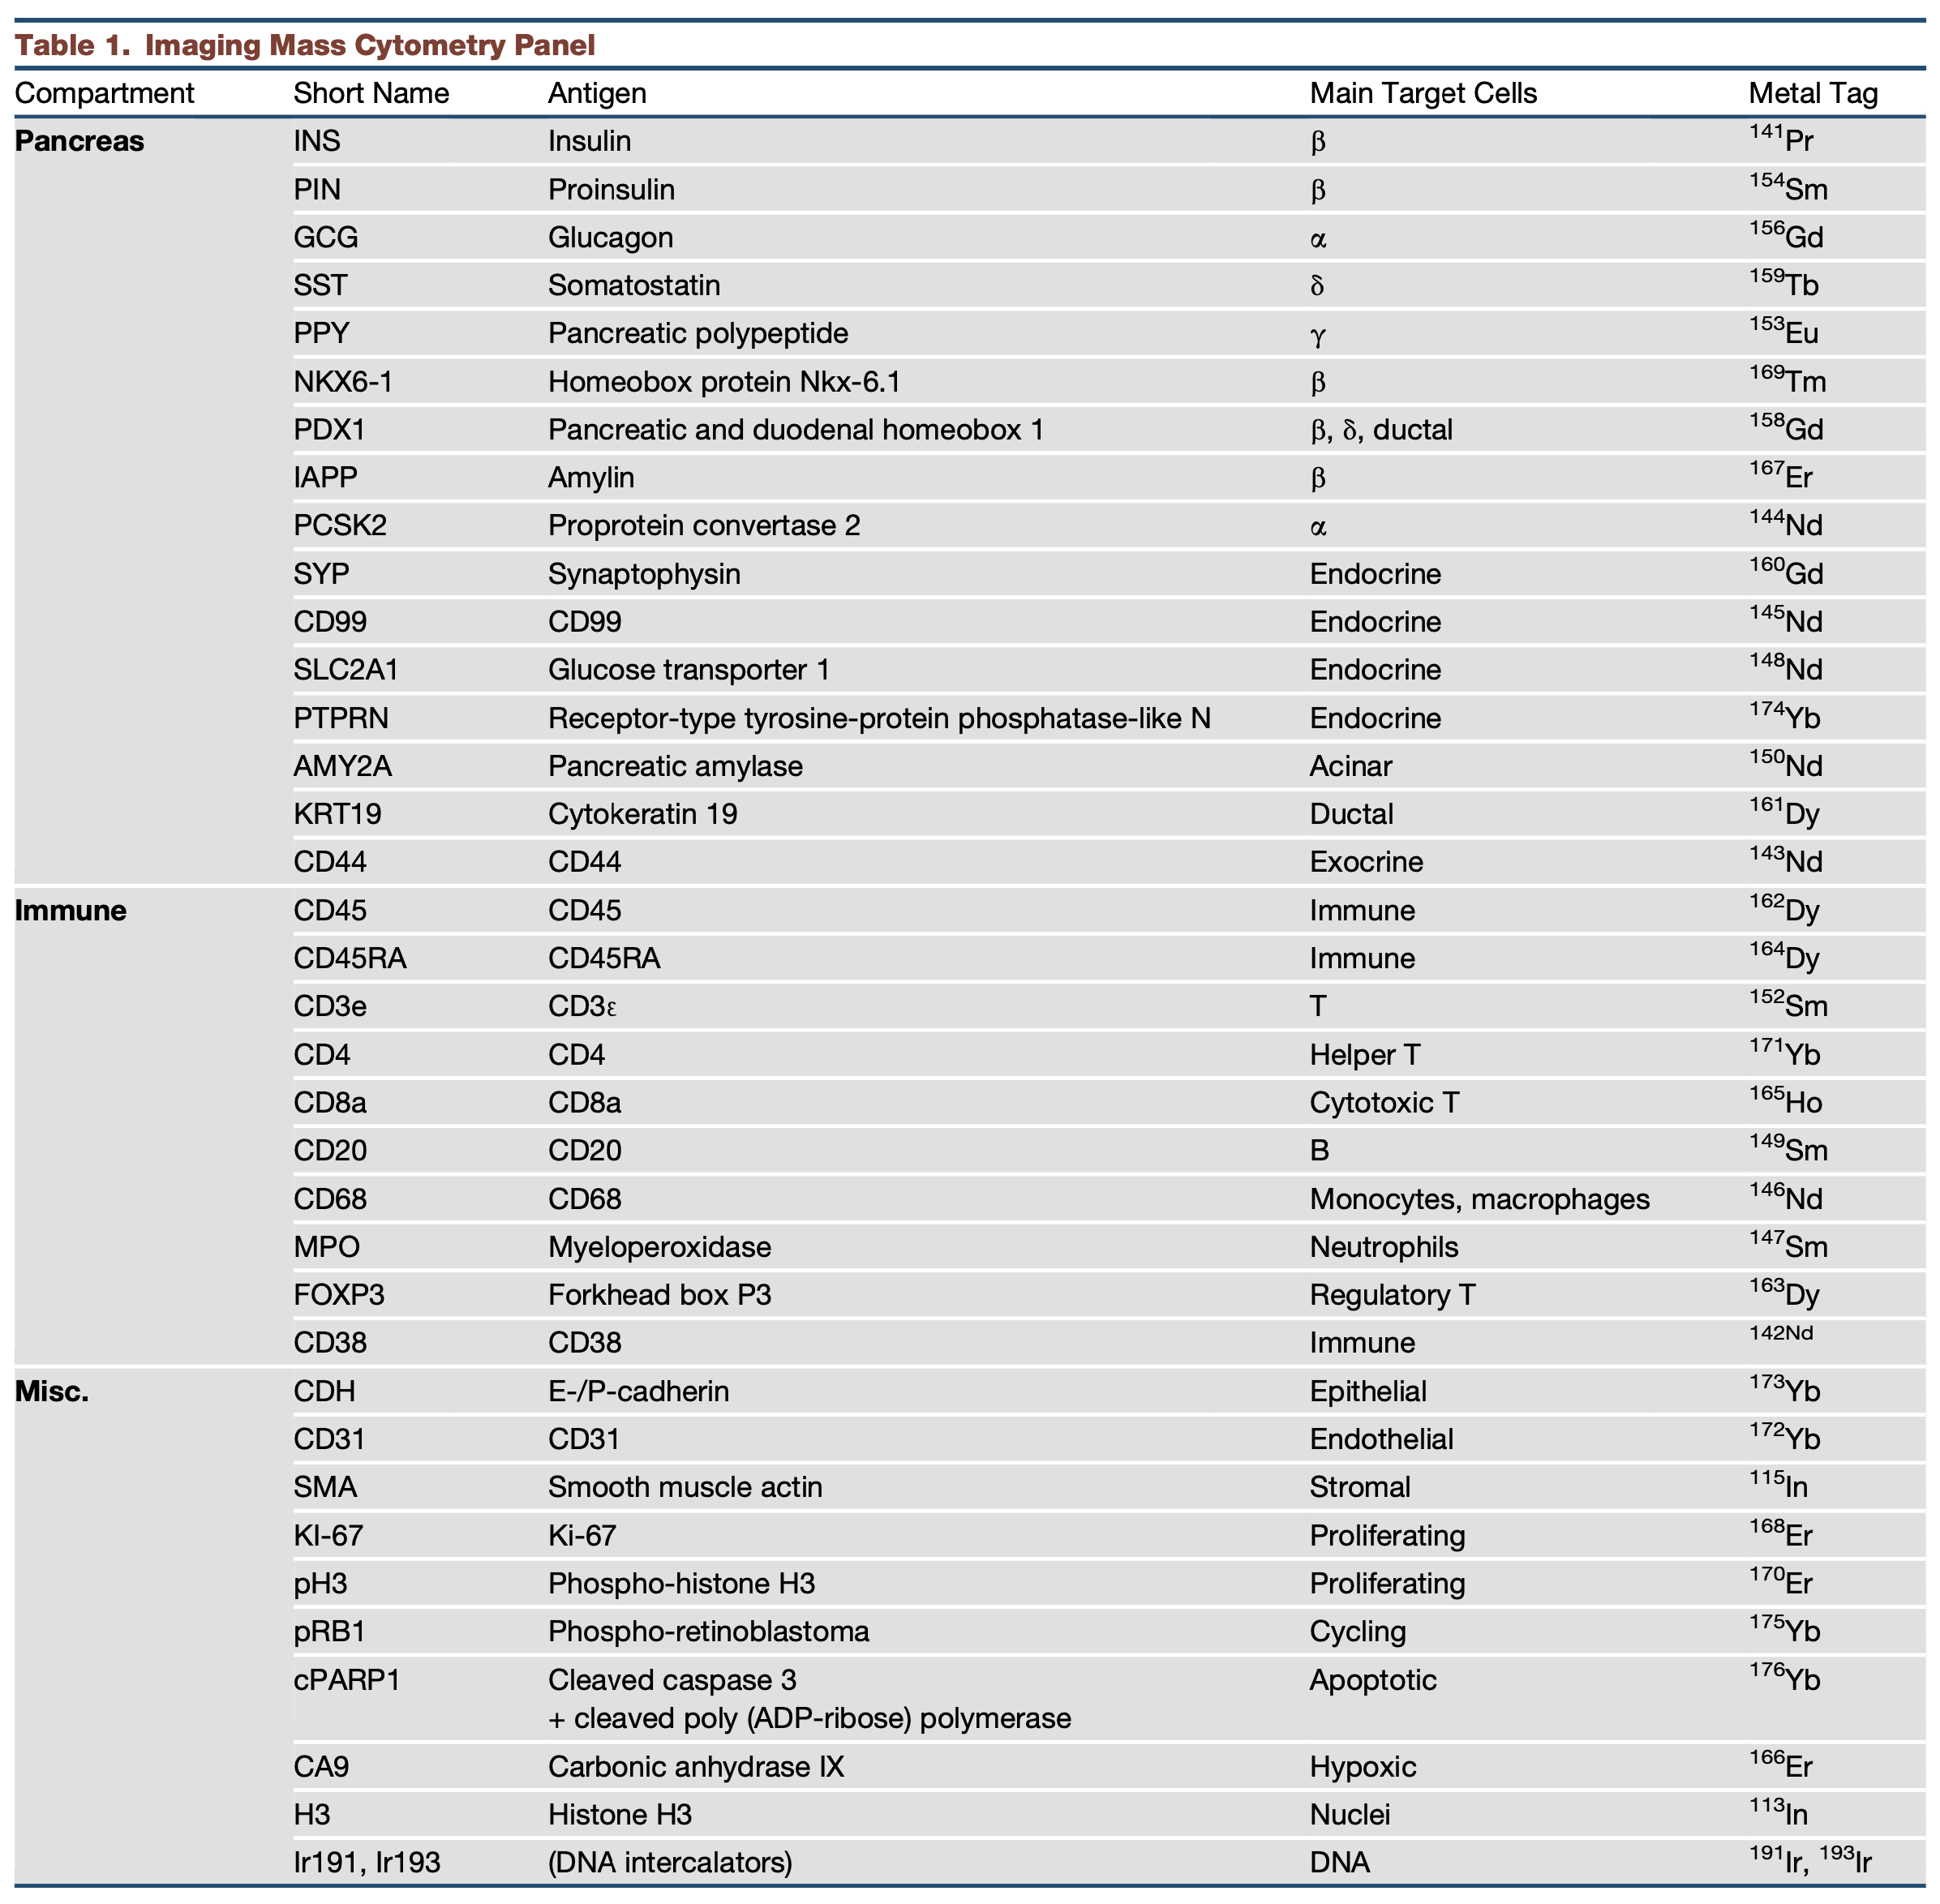

In [12]:
from IPython.display import Image
Image(filename = "./assets/BMED320_Damond_etal_2019_Tab1_IMC_panel.png", width=700)

In [13]:
df_p = pd.read_csv(fn_panel)
print(df_p.shape)
df_p

(37, 4)


,Short Name,Antigen,Main Target Cells,Metal Tag
0,INS,Insulin,β,141Pr
1,PIN,Proinsulin,β,154Sm
2,GCG,Glucagon,α,156Gd
3,SST,Somatostatin,δ,159Tb
4,PPY,Pancreatic polypeptide,γ,153Eu
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd
7,IAPP,Amylin,β,167Er
8,PCSK2,Proprotein convertase 2,α,144Nd
9,SYP,Synaptophysin,Endocrine,160Gd


### Insert IMC channel number in Panel data frame

In [14]:
df_p['Chn'] = np.array(range(len(df.chn)))
for idx, val in enumerate(list(df.chn)):
    s = (val[2:]+val[:2])
    for idx2, val2 in enumerate(list(df_p['Metal Tag'])):
        if  s==val2:
            df_p.Chn.iloc[idx2] = idx+1
df_p

,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
0,INS,Insulin,β,141Pr,3
1,PIN,Proinsulin,β,154Sm,15
2,GCG,Glucagon,α,156Gd,16
3,SST,Somatostatin,δ,159Tb,18
4,PPY,Pancreatic polypeptide,γ,153Eu,14
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm,28
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd,17
7,IAPP,Amylin,β,167Er,26
8,PCSK2,Proprotein convertase 2,α,144Nd,6
9,SYP,Synaptophysin,Endocrine,160Gd,19


In [15]:
fn = './data/E08_a0_panel_data_and_channel_numbering.csv'
df_p.to_csv(fn, encoding='utf-8', index=False)

In [16]:
df_p_sort_chn = df_p.sort_values('Chn')
df_p_sort_chn

,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
34,H3,Histone H3,Nuclei,113In,1
28,SMA,Smooth muscle actin,Stromal,115In,2
0,INS,Insulin,β,141Pr,3
25,CD38,CD38,Immune,142Nd,4
15,CD44,CD44,Exocrine,143Nd,5
8,PCSK2,Proprotein convertase 2,α,144Nd,6
10,CD99,CD99,Endocrine,145Nd,7
22,CD68,CD68,Monocytes macrophages,146Nd,8
23,MPO,Myeloperoxidase,Neutrophils,147Sm,9
11,SLC2A1,Glucose transporter 1,Endocrine,148Nd,10


In [17]:
fn = './data/E08_a0_panel_data_sorted_on_channel_numbering.csv'
df_p_sort_chn.to_csv(fn, encoding='utf-8', index=False)

### Pandas dataframe to LaTeX table
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_latex.html

In [18]:
print(df_p.to_latex(index=True)) 

\begin{tabular}{lllllr}
\toprule
{} & Short Name &                                            Antigen &      Main Target Cells & Metal Tag &  Chn \\
\midrule
0  &        INS &                                            Insulin &                      β &     141Pr &    3 \\
1  &        PIN &                                         Proinsulin &                      β &     154Sm &   15 \\
2  &        GCG &                                           Glucagon &                      α &     156Gd &   16 \\
3  &        SST &                                       Somatostatin &                      δ &     159Tb &   18 \\
4  &        PPY &                             Pancreatic polypeptide &                      γ &     153Eu &   14 \\
5  &     NKX6-1 &                           Homeobox protein Nkx-6.1 &                      β &     169Tm &   28 \\
6  &       PDX1 &                 Pancreatic and duodenal homeobox 1 &             β δ ductal &     158Gd &   17 \\
7  &       IAPP &             

In [19]:
print(df_p_sort_chn.to_latex(index=True)) 

\begin{tabular}{lllllr}
\toprule
{} & Short Name &                                            Antigen &      Main Target Cells & Metal Tag &  Chn \\
\midrule
34 &         H3 &                                         Histone H3 &                 Nuclei &     113In &    1 \\
28 &        SMA &                                Smooth muscle actin &                Stromal &     115In &    2 \\
0  &        INS &                                            Insulin &                      β &     141Pr &    3 \\
25 &       CD38 &                                               CD38 &                 Immune &     142Nd &    4 \\
15 &       CD44 &                                               CD44 &               Exocrine &     143Nd &    5 \\
8  &      PCSK2 &                            Proprotein convertase 2 &                      α &     144Nd &    6 \\
10 &       CD99 &                                               CD99 &              Endocrine &     145Nd &    7 \\
22 &       CD68 &             

### Write latex table directly to file, then use `\input(table.tex)` in Overleaf 
**remember `\usepackage{booktabs}`**

In [20]:
# Replace greek letter with mathematical greek in the Main Target Cells column
df_p_edit = df_p.copy()

old_list = ['α', 'β', 'δ', 'γ', 'β δ ductal']
new_list = ['$\\alpha$', '$\\beta$', '$\\delta$', '$\\gamma$', '$\\beta$ $\\delta$ ductal']
df_p_edit['Main Target Cells'] = df_p_edit['Main Target Cells'].replace(old_list, new_list)

# And add 1 to the index (i.e. panel antigen numbering)
df_p_edit.index = np.arange(1, len(df_p_edit)+1)
#df_p_edit.index.names = ['Channel']
df_p_edit['PanelNo'] = df_p_edit.index 

# Reorder columns to start with Channel
cols = list(df_p_edit.columns.values)
print(cols)
cols = [df_p_edit.columns[-1]] + [col for col in df_p_edit if col != df_p_edit.columns[-1]]
print(cols)
df_p_edit = df_p_edit[cols]

['Short Name', 'Antigen', 'Main Target Cells', 'Metal Tag', 'Chn', 'PanelNo']
['PanelNo', 'Short Name', 'Antigen', 'Main Target Cells', 'Metal Tag', 'Chn']


**Inspect**

In [21]:
df_p_edit

,PanelNo,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
1,1,INS,Insulin,$\beta$,141Pr,3
2,2,PIN,Proinsulin,$\beta$,154Sm,15
3,3,GCG,Glucagon,$\alpha$,156Gd,16
4,4,SST,Somatostatin,$\delta$,159Tb,18
5,5,PPY,Pancreatic polypeptide,$\gamma$,153Eu,14
6,6,NKX6-1,Homeobox protein Nkx-6.1,$\beta$,169Tm,28
7,7,PDX1,Pancreatic and duodenal homeobox 1,$\beta$ $\delta$ ductal,158Gd,17
8,8,IAPP,Amylin,$\beta$,167Er,26
9,9,PCSK2,Proprotein convertase 2,$\alpha$,144Nd,6
10,10,SYP,Synaptophysin,Endocrine,160Gd,19


**save to file to sync with Overleaf**

In [22]:
tab_fn = '%s/BMED320_experiments_case6126_E08_panel_table.tex' % fn_tab_base
with open(tab_fn, 'w') as tf:
     tf.write(df_p_edit.to_latex(index=False, escape=False))

UnicodeEncodeError: 'charmap' codec can't encode character '\u025b' in position 2493: character maps to <undefined>

### Plot the IMC dataset as a 7 x 6 grid of color-coded channels (and save Fig for the Overleaf document)

With histogram equalization for better visualization
https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy

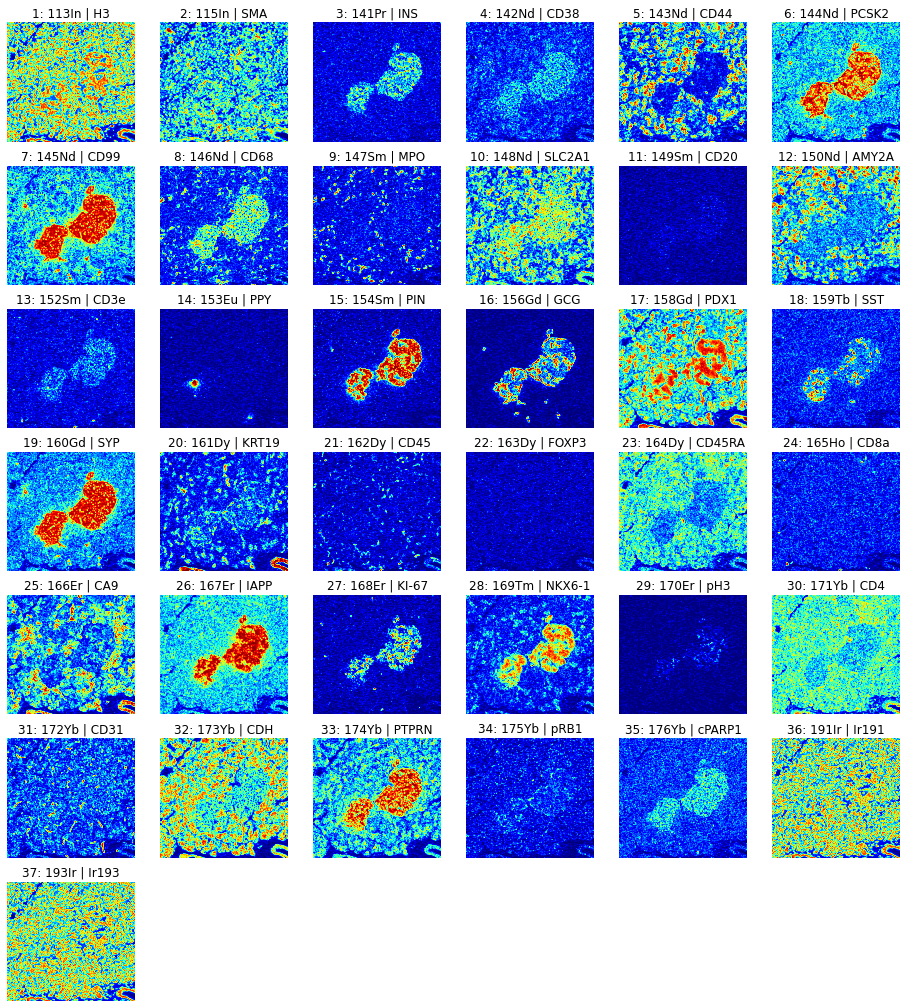

In [23]:
fig_fn = '%s/BMED320_experiments_case6126_E08_channel_eq_mosaic_jet.pdf' % fn_fig_base
fig, axes = plt.subplots(7, 6, figsize=(16, 18), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='jet' )   # cmap='jet', 'gray'
    ax[i].set_title('%d: %s | %s' % ((i+1), df_p_sort_chn['Metal Tag'].iloc[i], df_p_sort_chn['Short Name'].iloc[i]))
    ax[i].axis('off')
chn_0 = np.zeros(chn.shape )   
for j in range(n_chn,7*6):
    ax[j].imshow(chn_0, cmap='gray_r') 
    ax[j].axis('off')
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

### Plot the IMC dataset as a 7 x 6 grid of gray-level-coded channels¶

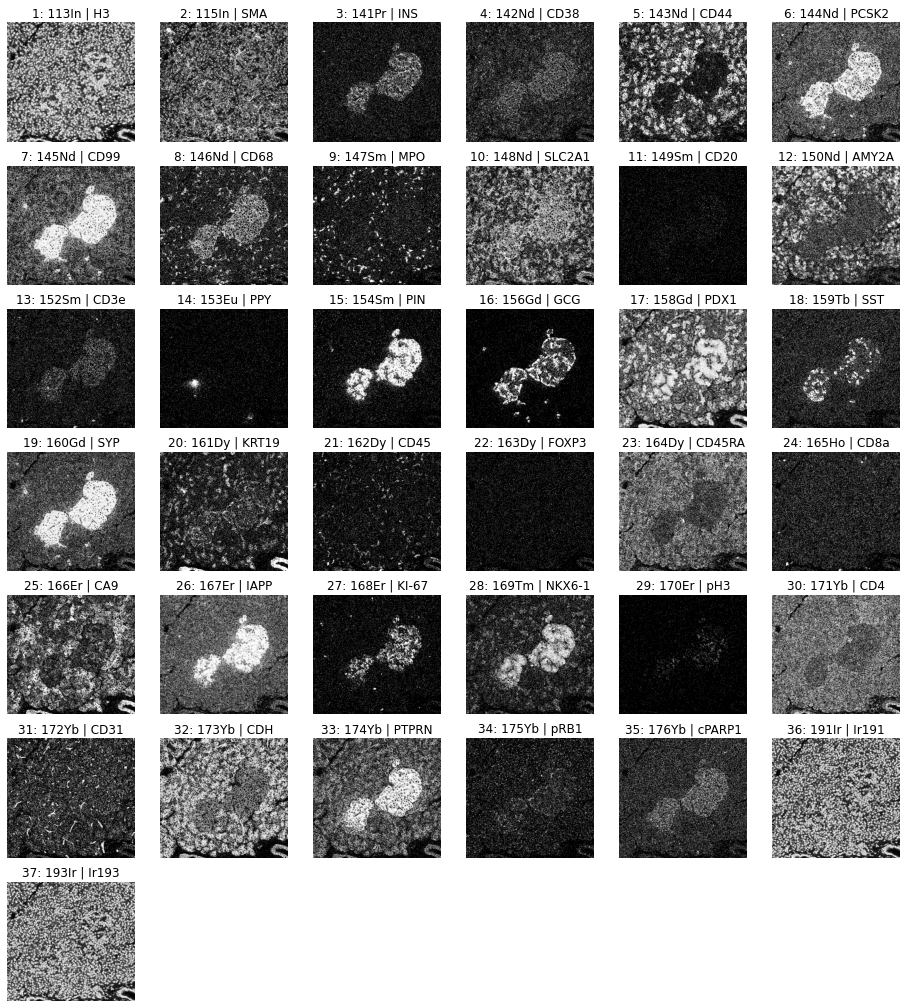

In [24]:
fig_fn = '%s/BMED320_experiments_case6126_E08_channel_eq_mosaic_gray.pdf' % fn_fig_base
fig, axes = plt.subplots(7, 6, figsize=(16, 18), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='gray' )   # cmap='jet', 'gray'
    ax[i].set_title('%d: %s | %s' % ((i+1), df_p_sort_chn['Metal Tag'].iloc[i], df_p_sort_chn['Short Name'].iloc[i]))
    ax[i].axis('off')
chn_0 = np.zeros(chn.shape )   
for j in range(n_chn,7*6):
    ax[j].imshow(chn_0, cmap='gray_r') 
    ax[j].axis('off')
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

## Prepare the multichannel IMC image for NIFTI format

In [25]:
im.shape

(37, 530, 567)

In [26]:
def hist_eq(chn):
    return np.sort(chn.ravel()).searchsorted(chn)

In [27]:
imc_img = np.zeros(shape=(im.shape[2], im.shape[1], 1, im.shape[0]))
imc_img_eq = np.zeros(shape=(im.shape[2], im.shape[1], 1, im.shape[0]))
print(imc_img.shape)
for i in range(im.shape[0]):
    a = np.squeeze(im[i,:,:])
    b = np.squeeze(hist_eq(im[i,:,:]))
    imc_img[:,:,0,i] = a[::-1,::-1].T /a.max()
    imc_img_eq[:,:,0,i] = b[::-1,::-1].T /b.max()

(567, 530, 1, 37)


### Make a neuroimaging NIFTI-formated multichannel image 
**(for using neuroimaging display tools like Freesurfer's [FreeView](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeviewGuide/FreeviewGeneralUsage/FreeviewInterface) or FSL's [FSLeyes](https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/userdoc/latest)**

In [28]:
imc_nii = nib.Nifti1Image(imc_img, affine=np.eye(4))
imc_nii_eq = nib.Nifti1Image(imc_img_eq, affine=np.eye(4))  # "histogram equalized channels" image

#### Save this NIFTI image to disk

In [29]:
nib.save(imc_nii, './data/imc_%d_chns.nii.gz' % (im.shape[0]))
nib.save(imc_nii_eq, './data/imc_%d_chns_eq.nii.gz' % (im.shape[0]))